### Observações importantes

Nesse notebook eu fiz baseado no [estudo de previsão de irradiância solar usando Regressão por vetores de suporte](https://repositorio.ufc.br/bitstream/riufc/45060/3/2018_tcc_jlogomes.pdf). Gomes, Jan Luccas de Oliveira. Com a adição de mais features, não só umidade, chuva, vento, e temperatura, mas como também adições de dias, mês, lags de até 14.
E com isso houve uma diferença muito grande no RMSE, no modelo baseado no estudo, portanto usando somente radiação e um lag de 14, o R2 =0.9014 e RMSE=3915.40 e esse gerou um R2 = 0.9258 e RMSE=0.0849.

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_row',1000)
pd.set_option('display.max_columns',40)

In [3]:
df = pd.read_csv('Dados/data_tratado.csv',sep=';')

In [4]:
def tirando_horas_sem_radiacao(df):
    condicao_irradiacao = (df.HORA<=19) & (df.HORA>=5)
    df = df[condicao_irradiacao]
    return df

ts = tirando_horas_sem_radiacao(df)

ts.loc[:,'DT_MEDICAO'] =  pd.to_datetime(df.loc[:,'DT_MEDICAO'], format='%Y-%m-%d')
ts.loc[:,'MES'] = ts.loc[:,'DT_MEDICAO'].dt.month
#criando a coluna ano
ts.loc[:,'ANO'] = ts.loc[:,'DT_MEDICAO'].dt.year
ts_dia = ts.groupby('DT_MEDICAO').agg({'RAD':'sum','CHUVA':'sum','ANO':'mean','MES':'mean','PRE_INS':'mean','UMD_MIN':'mean','PTO_MIN':'mean','VEN_DIR':'mean','TEM_MAX':'mean'})

ts.set_index('DT_MEDICAO',inplace=True)

### Baseado no trabalho

In [5]:
# import

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

In [6]:
# funçãoque cria a janela d previsão com N elementos

def create_lags(df,N):
    for i in range(N):
        df['Lag'+str(i+1)] = df.RAD.shift(i+1)
    return df

In [7]:
ts['day'] = ts.index.day
ts['dayofyear'] = ts.index.dayofyear
ts['weekday'] = ts.index.weekday
ts['weekofyear'] = ts.index.weekofyear

ts['month'] = ts.index.month
ts['is_month_start'] = ts.index.is_month_start
ts['is_month_end'] = ts.index.is_month_end

ts['year'] = ts.index.year
ts['is_year_start'] = ts.index.is_year_start
ts['ano_fim'] = ts.index.is_year_end

ts['quarter'] = ts.index.quarter
ts['quarter_comeco'] = ts.index.is_quarter_start
ts['quarter_fim'] = ts.index.is_quarter_end

ts = ts.dropna()

In [8]:
create_lags(ts,14)
ts = ts.dropna()
ts_copy = ts.copy()
ts.head()

,DC_NOME,PRE_INS,TEM_SEN,VL_LATITUDE,PRE_MAX,UF,RAD_GLO,PTO_INS,TEM_MIN,VL_LONGITUDE,UMD_MIN,PTO_MAX,VEN_DIR,CHUVA,PRE_MIN,UMD_MAX,VEN_VEL,PTO_MIN,TEM_MAX,VEN_RAJ,...,year,is_year_start,ano_fim,quarter,quarter_comeco,quarter_fim,Lag1,Lag2,Lag3,Lag4,Lag5,Lag6,Lag7,Lag8,Lag9,Lag10,Lag11,Lag12,Lag13,Lag14
DT_MEDICAO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01,SAO PAULO - MIRANTE,924.4,25.2,-23.496294,924.4,SP,23.658,16.1,25.2,-46.620088,49.0,16.1,260.0,0.0,924.1,57.0,1.3,14.0,25.7,9.4,...,2015,True,False,1,True,False,125.110,1724.781,2137.269,2752.190,3008.730,3682.655,3576.775,3485.912,2828.439,2405.176,1597.737,732.567,115.361,0.000
2015-01-02,SAO PAULO - MIRANTE,923.9,23.2,-23.496294,923.9,SP,-3.392,16.2,24.6,-46.620088,58.0,16.4,301.0,0.0,923.4,60.0,2.5,16.1,25.1,5.2,...,2015,False,False,1,False,False,0.000,125.110,1724.781,2137.269,2752.190,3008.730,3682.655,3576.775,3485.912,2828.439,2405.176,1597.737,732.567,115.361
2015-01-02,SAO PAULO - MIRANTE,924.4,24.4,-23.496294,924.4,SP,48.201,16.2,24.7,-46.620088,58.0,16.3,340.0,0.0,923.9,59.0,1.8,16.2,25.0,5.3,...,2015,False,False,1,False,False,0.000,0.000,125.110,1724.781,2137.269,2752.190,3008.730,3682.655,3576.775,3485.912,2828.439,2405.176,1597.737,732.567
2015-01-02,SAO PAULO - MIRANTE,925.2,24.7,-23.496294,925.2,SP,285.042,16.6,24.8,-46.620088,58.0,16.7,330.0,0.0,924.4,60.0,1.9,16.2,25.3,5.5,...,2015,False,False,1,False,False,48.201,0.000,0.000,125.110,1724.781,2137.269,2752.190,3008.730,3682.655,3576.775,3485.912,2828.439,2405.176,1597.737
2015-01-02,SAO PAULO - MIRANTE,925.7,24.8,-23.496294,925.7,SP,834.522,16.8,25.3,-46.620088,55.0,17.2,318.0,0.0,925.2,59.0,2.8,16.5,26.6,5.1,...,2015,False,False,1,False,False,285.042,48.201,0.000,0.000,125.110,1724.781,2137.269,2752.190,3008.730,3682.655,3576.775,3485.912,2828.439,2405.176


In [9]:
ts.columns

Index(['DC_NOME', 'PRE_INS', 'TEM_SEN', 'VL_LATITUDE', 'PRE_MAX', 'UF',
       'RAD_GLO', 'PTO_INS', 'TEM_MIN', 'VL_LONGITUDE', 'UMD_MIN', 'PTO_MAX',
       'VEN_DIR', 'CHUVA', 'PRE_MIN', 'UMD_MAX', 'VEN_VEL', 'PTO_MIN',
       'TEM_MAX', 'VEN_RAJ', 'TEM_INS', 'UMD_INS', 'CD_ESTACAO', 'HR_MEDICAO',
       'HORA', 'RAD', 'MES', 'ANO', 'day', 'dayofyear', 'weekday',
       'weekofyear', 'month', 'is_month_start', 'is_month_end', 'year',
       'is_year_start', 'ano_fim', 'quarter', 'quarter_comeco', 'quarter_fim',
       'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Lag6', 'Lag7', 'Lag8', 'Lag9',
       'Lag10', 'Lag11', 'Lag12', 'Lag13', 'Lag14'],
      dtype='object')

In [10]:
cols = ['TEM_INS', 'UMD_INS','VEN_RAJ', 'CHUVA','HORA','day', 'dayofyear', 'weekday', 'weekofyear', 'month',
        'is_month_start', 'is_month_end', 'year', 'is_year_start', 'ano_fim','quarter', 'quarter_comeco', 
        'quarter_fim', 'Lag1', 'Lag2', 'Lag3','Lag4', 'Lag5', 'Lag6', 'Lag7', 'Lag8', 'Lag9', 'Lag10', 'Lag11',
        'Lag12', 'Lag13', 'Lag14']

X = ts[cols]

y=np.log(ts['RAD']+1)  # log de y +1 pra não dar problema se zero!
X.shape, y.shape

((38341, 32), (38341,))

In [11]:
min_max_scaler = MinMaxScaler(feature_range=(0,1))

min_max_scaler.fit(X)
X_scaled = min_max_scaler.transform(X)

In [12]:
X_scaled=pd.DataFrame(X_scaled,columns=cols)

In [13]:
X_scaled[0:10]

,TEM_INS,UMD_INS,VEN_RAJ,CHUVA,HORA,day,dayofyear,weekday,weekofyear,month,is_month_start,is_month_end,year,is_year_start,ano_fim,quarter,quarter_comeco,quarter_fim,Lag1,Lag2,Lag3,Lag4,Lag5,Lag6,Lag7,Lag8,Lag9,Lag10,Lag11,Lag12,Lag13,Lag14
0,0.638554,0.529412,0.382114,0.0,1.000000,0.000000,0.00000,0.500000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.031281,0.431237,0.534369,0.688114,0.752255,0.920753,0.894280,0.871563,0.707178,0.601352,0.399473,0.183160,0.028843,0.000000
1,0.620482,0.552941,0.211382,0.0,0.000000,0.033333,0.00274,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.031281,0.431237,0.534369,0.688114,0.752255,0.920753,0.894280,0.871563,0.707178,0.601352,0.399473,0.183160,0.028843
2,0.629518,0.541176,0.215447,0.0,0.071429,0.033333,0.00274,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.031281,0.431237,0.534369,0.688114,0.752255,0.920753,0.894280,0.871563,0.707178,0.601352,0.399473,0.183160
3,0.638554,0.552941,0.223577,0.0,0.142857,0.033333,0.00274,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012051,0.000000,0.000000,0.031281,0.431237,0.534369,0.688114,0.752255,0.920753,0.894280,0.871563,0.707178,0.601352,0.399473
4,0.674699,0.505882,0.207317,0.0,0.214286,0.033333,0.00274,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071267,0.012051,0.000000,0.000000,0.031281,0.431237,0.534369,0.688114,0.752255,0.920753,0.894280,0.871563,0.707178,0.601352
5,0.713855,0.494118,0.215447,0.0,0.285714,0.033333,0.00274,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.208651,0.071267,0.012051,0.000000,0.000000,0.031281,0.431237,0.534369,0.688114,0.752255,0.920753,0.894280,0.871563,0.707178
6,0.771084,0.423529,0.292683,0.0,0.357143,0.033333,0.00274,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.284040,0.208651,0.071267,0.012051,0.000000,0.000000,0.031281,0.431237,0.534369,0.688114,0.752255,0.920753,0.894280,0.871563
7,0.798193,0.341176,0.430894,0.0,0.428571,0.033333,0.00274,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.518497,0.284040,0.208651,0.071267,0.012051,0.000000,0.000000,0.031281,0.431237,0.534369,0.688114,0.752255,0.920753,0.894280
8,0.822289,0.341176,0.463415,0.0,0.500000,0.033333,0.00274,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.850291,0.518497,0.284040,0.208651,0.071267,0.012051,0.000000,0.000000,0.031281,0.431237,0.534369,0.688114,0.752255,0.920753
9,0.840361,0.294118,0.386179,0.0,0.571429,0.033333,0.00274,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.882924,0.850291,0.518497,0.284040,0.208651,0.071267,0.012051,0.000000,0.000000,0.031281,0.431237,0.534369,0.688114,0.752255


In [14]:
# Define e normaliza as entradas X e saídas Y e divide em 70% para treino e 30% pra teste
y = y
X = X_scaled

In [15]:
X.shape, y.shape

((38341, 32), (38341,))

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.33, 
                                                    random_state=42)

In [19]:
#Cria uma SVR, treina e prediz os valores
reg = SVR(kernel='rbf', C=1.0, epsilon=0.01)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

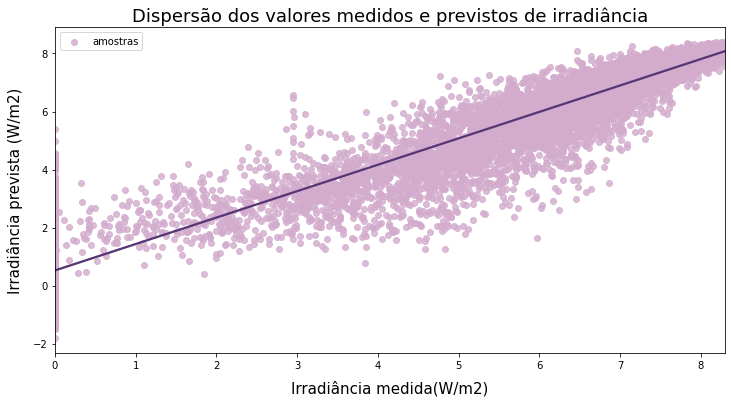

In [25]:
fig = plt.figure(figsize=(12, 6))
fig.set_facecolor("#fff")
ax = fig.add_subplot()
ax.set_facecolor("#fff")
plt.title('Dispersão dos valores medidos e previstos de irradiância',fontsize=18)
ax=sns.regplot(y_test, y_pred,color='#d3accd',label='amostras',line_kws={'color':'#563674'})
ax.set_ylabel('Irradiância prevista (W/m2)', fontsize=15, fontweight="normal", labelpad=10)
ax.set_xlabel('Irradiância medida(W/m2)', fontsize=15, fontweight="normal", labelpad=10)
plt.legend(loc='upper left');

In [26]:
pd.DataFrame(y_test-y_pred).describe().T

,count,mean,std,min,25%,50%,75%,max
RAD,12653.0,-0.035712,0.748112,-5.396661,-0.260944,0.00463,0.236779,4.321768


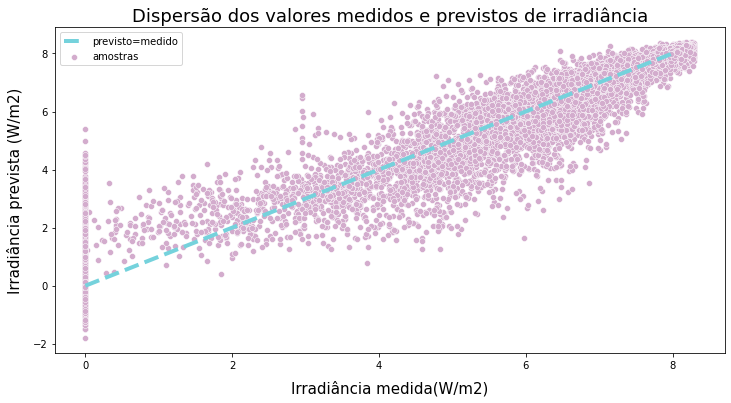

In [28]:
p = np.array([0,8])
fig = plt.figure(figsize=(12, 6))
fig.set_facecolor("#fff")
ax = fig.add_subplot()
ax.set_facecolor("#fff")
plt.title('Dispersão dos valores medidos e previstos de irradiância',fontsize=18)
ax =plt.plot(p,p,color='#75d2dc',label='previsto=medido', lw=4,ls='--')
ax=sns.scatterplot(y_test, y_pred, color='#d3accd',label='amostras')
ax.set_ylabel('Irradiância prevista (W/m2)', fontsize=15, fontweight="normal", labelpad=10)
ax.set_xlabel('Irradiância medida(W/m2)', fontsize=15, fontweight="normal", labelpad=10)
plt.legend(loc='upper left');

In [29]:
# função que  calcula o erro percentual para cada previsão, em que 
## erro =vetor de erros percentuais para cada amostra

def erro(test,pred):
    erro=np.repeat(0,len(test))
    for i in range(len(test)):
        if test[i]==0:
            erro[i]=0
        else:
            erro[i]=100*(np.abs(test[i]-pred[i]))/test[i]
    return erro

In [30]:
erro = erro(y_test,y_pred)
erro

array([2, 0, 0, ..., 5, 0, 6])

In [31]:
erro.mean(), erro.std()

(8.371137279696514, 80.25828412677437)

In [32]:
pd.DataFrame(erro).describe().T

,count,mean,std,min,25%,50%,75%,max
0,12653.0,8.371137,80.261456,0.0,0.0,2.0,6.0,6447.0


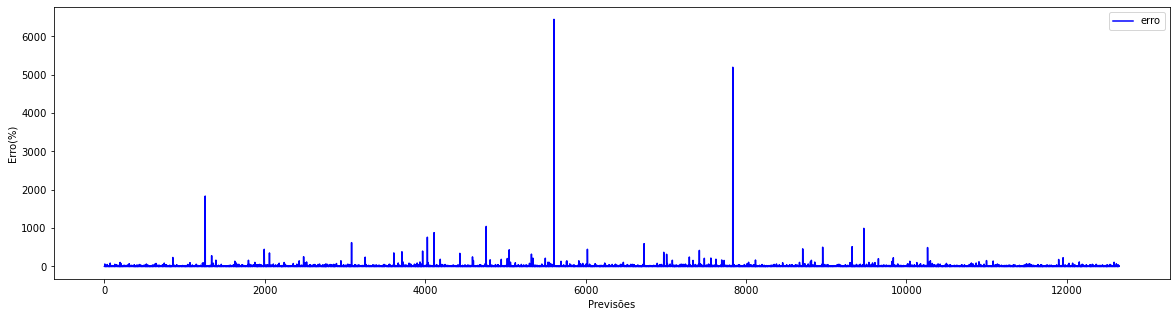

In [35]:
plt.figure(figsize=(20,5))
plt.plot( erro, color='blue', label='erro')
plt.xlabel('Previsões')
plt.ylabel('Erro(%)')
plt.legend();

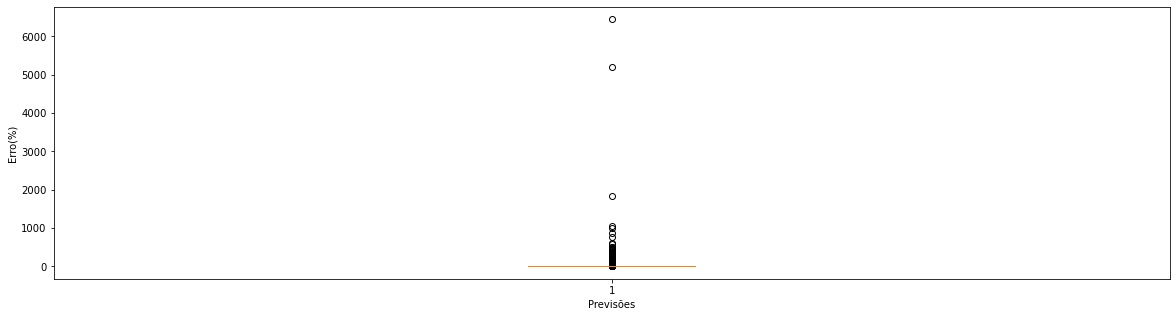

In [36]:
plt.figure(figsize=(20,5))
plt.boxplot( erro)
plt.xlabel('Previsões')
plt.ylabel('Erro(%)');

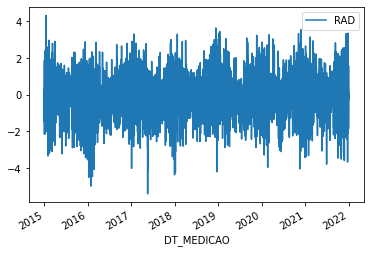

In [40]:
pd.DataFrame(y_test-y_pred).plot();

In [41]:
#função que calcula os erros menos ou iguais a n % em que
## err= vetor de erros percentuais

def percent_erro(erro,n):
    cont=0
    for i in range(len(erro)):
        if erro[i]<=n:
            cont=cont+1
    return 100*cont/(len(erro))       

In [42]:
# função que calcula os erros menores que %n entre período de horas
## em que :  hor=vetor de horas
##           h_ini = hora inicial
##           h_fin = hora final

def percent_erro_hora(erro=erro, hor = df['HORA'], h_ini=None,h_fin=None,n=None):
    cont_erro = 0
    cont_hora = 0
    for i in range(len(erro)):
        if hor.iloc[i]>=h_ini and df['HORA'].iloc[i]<h_fin:
            cont_hora = cont_hora+1
            if err[i]<=n:
                cont_erro=cont_erro+1
                
    return 100*cont_erro/cont_hora


In [43]:
percent_erro(erro,23) # mais de 41,59% dos erros são menores ou igual a 23%

93.29803208725204

In [44]:
# Cálculo do erro médio quadrático 

rmse = sqrt(mean_squared_error(y_test, y_pred))
rmse

0.7489342038760965

In [45]:
# Cálculo do coeficiente de determinação R2
r2_score(y_test,y_pred)

0.9326743176710464

In [46]:
y_hat = reg.predict(X_train)
r2_score(y_train,y_hat)

0.9334646489528687

In [47]:
# função para cálculo do erro médio quadrático normalizado, em que:
## test = dados medidos do período de teste
## pred = dados previstos para o período de teste

def n_rmse(test, pred):
    erro=np.repeat(0, len(test))
    media = (sum(test)/len(test))
    soma = 0
    for i in range(len(test)):
        erro[i]=((pred[i]-test[i])/(media))**2
        soma=soma+erro[i]
    return 100*(soma/(len(test)))**(1/2)


In [48]:
n_rmse(y_test,y_pred)

0.0

---

In [ ]:
https://app.powerbi.com/view?r=eyJrIjoiY2VmMmUwN2QtYWFiOS00ZDE3LWI3NDMtZDk0NGI4MGU2NTkxIiwidCI6IjQwZDZmOWI4LWVjYTctNDZhMi05MmQ0LWVhNGU5YzAxNzBlMSIsImMiOjR9